# HW 2: PCA and t-SNE Ramson Munoz Morales

In [1]:
from IPython.display import HTML
HTML("""
<style>
/* center the main column */
div#notebook, .jp-Notebook {
  max-width: 900px;
  margin: 0 auto !important;
}

/* hide In[ ] and Out[ ] prompts */
div.prompt, .jp-InputPrompt, .jp-OutputPrompt {
  display: none !important;
}

/* wrap long code lines (editor + rendered html) */
.CodeMirror pre { white-space: pre-wrap; word-break: break-word; }
.jp-Notebook .cm-content { white-space: pre-wrap; word-break: break-word; }
.rendered_html pre, .highlight pre { white-space: pre-wrap; word-break: break-word; }
</style>
""")


## Loading Data

In [2]:
import pandas as pd
from pathlib import Path

ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
DATA_DIR = ROOT / "data"
SPLIT_DIR = ROOT / DATA_DIR / "cv_splits"
SPLIT_DIR.mkdir(parents=True,exist_ok=True)

data_file_name = "lncRNA_5_Cancers.csv"
data_path = DATA_DIR / data_file_name

data = pd.read_csv(data_path)
#print(data)

## Task 1

Task 1: [25 points] Visualize the lncRNA expression data of five different cancer types using
PCA. Reduce the data dimension from 12,309 to two (PC1 and PC2) dimensions and plot the
data into reduced dimensions. Must plot all the data of five cancer types.

With the data loaded, we will be applying the Sci kit learn implmentation of PCA and t-SNE.
### Running the Dimension Reduction

In [3]:
import numpy as np 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca = PCA(n_components=2)# initializing a PCA object that will redecue dimension of input to 2
scaled_pca = PCA(n_components=2)
# Selecting features from data table 
feature_set = data.to_numpy()[:,1:data.shape[1] - 1]
#print(feature_set.shape)

# Scalling Data
scaled_features = StandardScaler().fit_transform(feature_set)

# Applying reduction
#components = pca.fit_transform(scaled_features)
components = pca.fit_transform(feature_set)
scaled_components = scaled_pca.fit_transform(scaled_features)

# Diagnostic report on chosen components
var_explained = pca.explained_variance_ratio_ * 100
scaled_var_explained = scaled_pca.explained_variance_ratio_ * 100
print("Percent Variance explained by unscaled PCA_Feature_1: %.2f" % var_explained[0])
print("Percent Variance explained by unscaled PCA_Feature_2: %.2f" % var_explained[1])
print("Percent Variance explained by scaled PCA_Feature_1: %.2f" % scaled_var_explained[0])
print("Percent Variance explained by scaled PCA_Feature_2: %.2f" % scaled_var_explained[1])

Percent Variance explained by unscaled PCA_Feature_1: 14.82
Percent Variance explained by unscaled PCA_Feature_2: 10.18
Percent Variance explained by scaled PCA_Feature_1: 11.65
Percent Variance explained by scaled PCA_Feature_2: 4.90


These values seem a little low. I may have implemented this in correctly. Checking Scree plot to see what the components distribution looks like

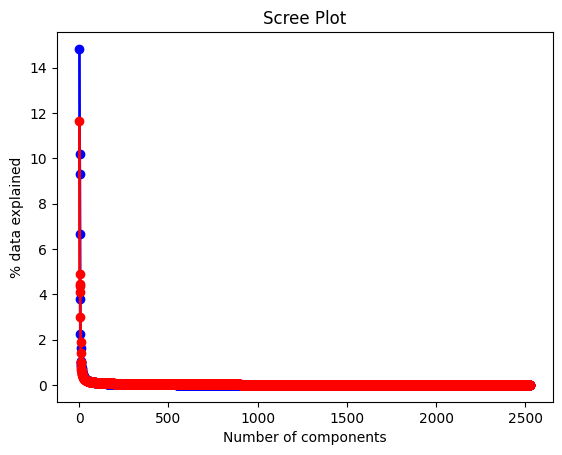

In [4]:
import matplotlib.pyplot as plt
pca_full = PCA()
scaled_pca_full = PCA()

scaled_pca_full.fit(scaled_features)
pca_full.fit(feature_set)
'''
Running the fit on the full feature set without specifying the n_components defaults to returning all components which allows a view of the distribution of components.
'''
features = np.arange(pca_full.n_components_) + 1 # +1 because index starts at 0 and this makes it human readable in the plot this is effectively doing [n_1, ..., n_k] + [1,...,1]
plt.plot(features,pca_full.explained_variance_ratio_ * 100,
         linestyle='-',
         color='blue',           # line color
         marker='o',
         markerfacecolor='blue', # dot fill
         markeredgecolor='blue', linewidth=2)

# Testing against scaled data
scaled_pca_full.fit(scaled_features)
scaledfeatures = np.arange(scaled_pca_full.n_components_) + 1 # +1 because index starts at 0 and this makes it human readable in the plot this is effectively doing [n_1, ..., n_k] + [1,...,1]
plt.plot(scaledfeatures,scaled_pca_full.explained_variance_ratio_ * 100,
         linestyle='-',
         color='red',           # line color
         marker='o',
         markerfacecolor='red', # dot fill
         markeredgecolor='red', linewidth=2)

plt.title("Scree Plot")
plt.xlabel("Number of components")
plt.ylabel("% data explained")
plt.show()

This provides a little more confidence. The chosen components are in line with what I expect given the scree plot. Although it is curious to note that we dont return the feature dimenson, rather the sample dimension. if we include all components. There might be something up here with the way it is being implemented.

One thing that is is clear when comparing the scalled data in red with the unscaled data in blue is that we have much lower variance explained by each addtional component for the first 10 or so components.

### Plotting Data using Components

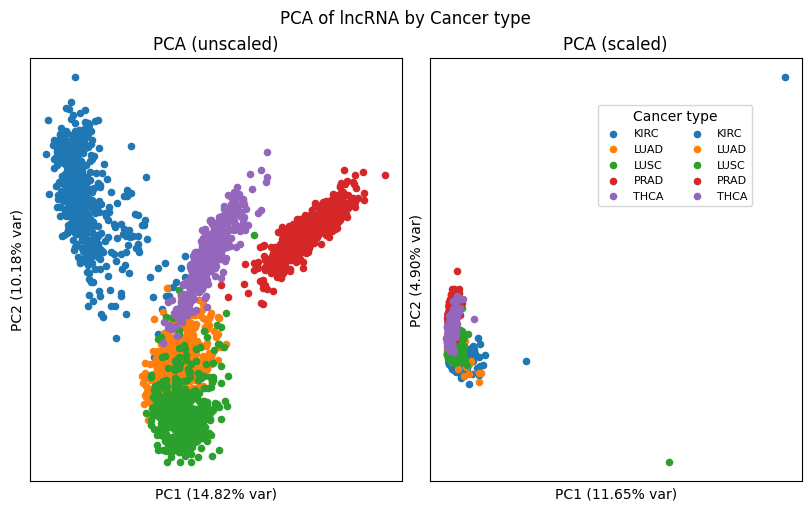

In [5]:
from matplotlib.colors import ListedColormap
# Pulling Cancer Label names 
classes = data['Class'].unique().tolist()
labels = data['Class']

#print(components.shape,labels.shape)
# Pulling Colors for each cancer in label
cmap = ListedColormap(plt.rcParams['axes.prop_cycle'].by_key()['color'][:len(classes)])

# Creating map
color_map = {cls: cmap(i) for i, cls in enumerate(classes)}

# Initializing plot
fig, axes = plt.subplots(1, 2, figsize=(8, 5), constrained_layout=True)
axL, axR = axes

# Creating a mask for color graphing and graphing based on mask
for cancer in classes:
    mask = (labels == cancer)
    axL.scatter(components[mask,0],components[mask,1],s=20,label=str(cancer),facecolors=color_map[cancer])
    axR.scatter(scaled_components[mask,0],scaled_components[mask,1],s=20,label=str(cancer),facecolors=color_map[cancer])
    

# Labels,Legened, Config

## Unscaled Data
axL.set_xlabel(f"PC1 ({var_explained[0]:.2f}% var)")
axL.set_xticks([]) # Hiding xticks since they don't provide meaningful info
axL.set_ylabel(f"PC2 ({var_explained[1]:.2f}% var)")
axL.set_yticks([]) # Hiding yticks since they don't provide meaningful info
axL.set_title("PCA (unscaled)")

## Scaled Data
axR.set_xlabel(f"PC1 ({scaled_var_explained[0]:.2f}% var)")
axR.set_xticks([]) # Hiding xticks since they don't provide meaningful info
axR.set_ylabel(f"PC2 ({scaled_var_explained[1]:.2f}% var)")
axR.set_yticks([]) # Hiding yticks since they don't provide meaningful info
axR.set_title("PCA (scaled)")

## Global Plot params
fig.suptitle("PCA of lncRNA by Cancer type")
fig.legend(title="Cancer type",ncols=2,fontsize=8,loc="right",bbox_to_anchor=(0.94, 0.7))
plt.show()



I would like to note that I originally scaled the data before plotting. The data ended up bunching together and was harder to visualize. The results of that are evident in the left subplot. I expect that this is likely because there is a lot more similarity in the data than originally expected. To test this, it would help to compare similar samples for a model RNA set to this sample. The clustering the the given sample may be a result of similarities in the host species so the additional data could help eliminate that possibility. 

In the unscaled subplot above, we see the different regions belonging to the different cancer types. This view provides a more local view of the data distribution based on the actual data. There is clear separation for the PRAD and KIRC which lines up with last weeks analysis as these were the least likely cancers to be mislabeled. Further, the lung cancers (green and orange) seem to have the greatest degree of overlap alongside slight overlap with the thyroid cancer (purple). Our two components only account for a total 25% of the variance in the data however; so, I imagine that the first 10 components would be necessary to capture the topography of the data surface better. This is backed up by the scree plot above.

Although this is not included in the scope of this project, I am going to plot a 3 component surface to see if the added axis adds more separation. However, this further analysis will focus on the unscaled data.
### Extra analysis: Plotting on 3D (3-component) surface

In [8]:
import plotly.graph_objects as go
import matplotlib.colors as mcolors

# Initializing three component PCA
three_dimensional_pca = PCA(n_components=3)

#Applying projection
three_comp = three_dimensional_pca.fit_transform(feature_set)

# Diagnostics
three_dim_var_explained = three_dimensional_pca.explained_variance_ratio_

color_map_plotly = {k: mcolors.to_hex(v) for k, v in color_map.items()}

# Plotting interactive 3D plot
fig = go.Figure()
'''
Using the plotly graph objects to plot interactive 3d mapping because I think this will give us a better sense of the topography of the data
'''
for cancer in classes:
    mask = (labels == cancer)
    fig.add_trace(go.Scatter3d(
        x = three_comp[mask,0],
        y = three_comp[mask,1],
        z = three_comp[mask,2],
        mode="markers",
        name=str(cancer),
        marker=dict(size=3,opacity=0.9,color=color_map_plotly[cancer]),
        hovertemplate="PC1=%{x:.3f}<br>PC2=%{y:.3f}<br>PC3=%{z:.3f}<br>Class="+str(cancer)+"<extra></extra>"
    ))
    
fig.update_layout(
    scene=dict(
        xaxis_title = "PC1", yaxis_title = "PC2", zaxis_title = "PC3",
        aspectmode="data"
    ),
    template="plotly_white",
    margin=dict(l=0,r=0,t=0,b=0),
    legend_title_text="Class"
)

fig.show()


The 3D view provides a better understanding of how the data is clustered. We can see an image taken from the interactive plot here:

<img src="../reports/3d_PCA.png" alt="My Image" style="height: 500px; width:800px;" />

This shows us that the overlap between the lung cancers that we expected from HW_1. Further, there is a clearer spatial separation between the other cancer types.
## Task 2
Task 2: [25 points] Draw two violon plots – one with the values of PC1 and the other with
PC2.

Text(0.5, 1.0, 'Violin Plot for Two-Component PCA of lncRNA data')

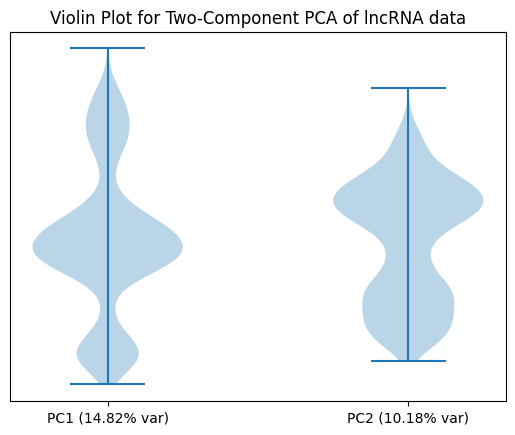

In [22]:
# Violin plot using matplotlib
plt.violinplot(components,showmeans=False,showmedians=False)
plt.xticks([1,2],[f"PC1 ({var_explained[0]:.2f}% var)",f"PC2 ({var_explained[1]:.2f}% var)"])
plt.yticks([])
plt.title("Violin Plot for Two-Component PCA of lncRNA data")


From the violin plots above we can see the distributions for each of the components. As expected, the plot for PC1 has a greater dispersion than PC2 since it explains more variance in the data. Both distributions are multimodel, however this data alone is not sufficient to explain wether this multimodality comes from the different cancer types or not. 
## Task 3
Task 3: [25 points] Repeat task 1 using t-SNE library. Plot the data in reduced dimension using
two t-SNE components (t-SNE 1 and t-SNE 2).

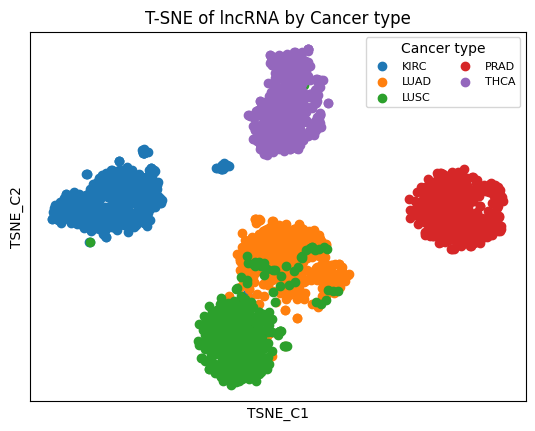

In [ ]:
from sklearn.manifold import TSNE

# Initializng TSNE
tsne = TSNE(n_components=2)

# Applying projections
tsne_components = tsne.fit_transform(feature_set)


# Creating a mask for color graphing and graphing based on mask
for cancer in classes:
    mask = (labels == cancer)
    plt.scatter(tsne_components[mask,0],tsne_components[mask,1],label=str(cancer))
    

# Labels,Legened, Config
plt.xlabel(f"TSNE_C1")
plt.xticks([]) # Hiding xticks since they don't provide meaningful info
plt.ylabel(f"TSNE_C2")
plt.yticks([]) # Hiding yticks since they don't provide meaningful info
plt.title("T-SNE of lncRNA by Cancer type")
plt.legend(title="Cancer type",ncols=2,fontsize=8,loc="upper right")
plt.show()
